## The goal of Decision Tree is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. 

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import sys
sys.path.append('../common')

from print_more_stuff import print_more_stuff
from regression_models import dosomething

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
outliers_df = pd.read_csv('outliers.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7617 entries, 0 to 7616
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             7617 non-null   float64
 1   bath            7617 non-null   float64
 2   acre_lot        7617 non-null   float64
 3   zip_code        7617 non-null   float64
 4   house_size      7617 non-null   float64
 5   prev_sold_date  7617 non-null   object 
 6   price           7617 non-null   float64
dtypes: float64(6), object(1)
memory usage: 416.7+ KB


#### Create new feature prev_sold_year from prev_sold_date

In [4]:
outliers_df["prev_sold_year"] = pd.to_datetime(outliers_df["prev_sold_date"], format='%Y-%m-%d').dt.year
outliers_df.drop(columns=["prev_sold_date"],inplace=True)
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7617 entries, 0 to 7616
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             7617 non-null   float64
 1   bath            7617 non-null   float64
 2   acre_lot        7617 non-null   float64
 3   zip_code        7617 non-null   float64
 4   house_size      7617 non-null   float64
 5   price           7617 non-null   float64
 6   prev_sold_year  7617 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 416.7 KB


#### Create a new feature in the housing data for Zip Code with a leading zero

In [5]:
outliers_df["zip_code_str"] = np.where(outliers_df.zip_code.apply(int) < 10000,'0'+ outliers_df.zip_code.apply(int).apply(str),outliers_df.zip_code.apply(int).apply(str))
outliers_df.head()

,bed,bath,acre_lot,zip_code,house_size,price,prev_sold_year,zip_code_str
0,3.0,2.0,0.14,7001.0,1542.0,305100.0,2022,07001
1,3.0,2.0,0.11,7001.0,1500.0,479000.0,2016,07001
2,3.0,2.0,0.17,7001.0,7501.0,340000.0,2021,07001
3,5.0,2.0,0.18,7001.0,1387.0,484000.0,2020,07001
4,3.0,2.0,0.17,7001.0,1500.0,425000.0,2019,07001


#### Create a new feature in the Lat/Long data for Zip Code with a leading zero

In [6]:
zip_lon_lat = pd.read_csv('nj_zip-lon-lat.csv')
zip_lon_lat["zip_code_str"] = np.where(zip_lon_lat.zip_code.apply(int) < 10000,'0'+ zip_lon_lat.zip_code.apply(int).apply(str),zip_lon_lat.zip_code.apply(int).apply(str))
zip_lon_lat.head()

,zip_code,latitude,longitude,zip_code_str
0,7001,40.582316,-74.271506,07001
1,7002,40.662338,-74.110275,07002
2,7003,40.809128,-74.187155,07003
3,7004,40.882508,-74.304593,07004
4,7005,40.932771,-74.417304,07005


#### Merge the Lat/Long data with the housing data using Zip Code with a leading zero

In [7]:
merged_df = pd.merge(outliers_df, zip_lon_lat, how='inner', on="zip_code_str")
merged_df.tail()

,bed,bath,acre_lot,zip_code_x,house_size,price,prev_sold_year,zip_code_str,zip_code_y,latitude,longitude
7609,5.0,4.0,0.91,8848.0,1500.0,485000.0,2017,08848,8848,40.594266,-75.096659
7610,4.0,3.0,2.17,8825.0,1500.0,510000.0,2016,08825,8825,40.514169,-75.027112
7611,3.0,2.0,0.12,7012.0,1500.0,499000.0,2021,07012,7012,40.848398,-74.160266
7612,3.0,3.0,0.13,7012.0,1500.0,530000.0,2022,07012,7012,40.848398,-74.160266
7613,4.0,3.0,0.11,7640.0,1500.0,720000.0,2016,07640,7640,40.991681,-73.980202


#### Create common variables to store frequently used values.

In [8]:
features = ["latitude","longitude","bed","bath","house_size","prev_sold_year"]
num_features_to_select = len(features)-1
random_state_value = 42

#### Datasets for modeling, testing the models, and making predictions.

In [9]:
X = merged_df[features]
y = merged_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

#### Variable to store the results generated by the models.

In [10]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[], "mean fit time":[]}

#### Function to format the results generated by the models.

In [11]:
def results_dict_append(rtnval):
    results_dict["model"].append(rtnval["model"])
    results_dict["explained variance score"].append(rtnval["explained variance score"])
    results_dict["mae score"].append(rtnval["mae score"])
    results_dict["mse score"].append(rtnval["mse score"])
    results_dict["r2 score"].append(rtnval["r2 score"])
    results_dict["mean fit time"].append(rtnval["mean fit time"])

### GridSearchCV exhaustively generates candidates from a grid of parameter values specified.

In [12]:
params = {'max_depth': range(5,15,1),
         'random_state':[42]}

grid = GridSearchCV(DecisionTreeRegressor(), param_grid=params).fit(X_train, y_train)
grid_train_acc = grid.score(X_train, y_train)
grid_test_acc = grid.score(X_test, y_test)
best_params = grid.best_params_
best_params

{'max_depth': 8, 'random_state': 42}

#### The best params attribute will be used to fit  model with the training data and make a prediction with the test data.

In [13]:
dtree = dosomething("Decision Tree","Decision Tree Best Params", merged_df, features, "price", best_params)
results_dict_append(dtree["results"])
dtree_bp_predict = dtree["predictions"]

Decision Tree Best Params EVS = 0.525465856
Decision Tree Best Params MSE = 76,497,959,521.268478
Decision Tree Best Params MAE = 161,667.633996
Decision Tree Best Params R2 = 0.524659
Decision Tree Best Params Fit Time = 0.009049510955810547


#### cost_complexity_pruning_path

path = dtree.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas = path.ccp_alphas
impurities = path.impurities

plt.step(ccp_alphas[:-1], impurities[:-1], '--o')
plt.title('Impurity vs. Effective Alpha')
plt.xlabel('Effective Alphas')
plt.ylabel('Total Impurity of Leaves');

### Recursive feature elimination uses an external estimator that assigns weights to features with the goal of selecting features by recursively considering smaller and smaller sets of features.

In [14]:
dtree_rfe = dosomething("Decision Tree","Recursive Feature Elimination", merged_df, features, "price")
results_dict_append(dtree_rfe["results"])
dtree_rfe_predict = dtree_rfe["predictions"]

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'house_size']
Recursive Feature Elimination EVS = 0.440904030
Recursive Feature Elimination MSE = 90,111,993,366.970032
Recursive Feature Elimination MAE = 167,341.540176
Recursive Feature Elimination R2 = 0.440065
Recursive Feature Elimination Fit Time = 0.02732996940612793


###  Sequential Feature Selector (forward selection) adds features to form a feature subset in a greedy fashion. At each stage, this estimator chooses the best feature to add or remove based on the cross-validation score of an estimator. 

In [15]:
dtree_sfs = dosomething("Decision Tree","Sequential Feature Selector", merged_df, features, "price")
results_dict_append(dtree_sfs["results"])
dtree_sfs_predict = dtree_sfs["predictions"]

The selected features are: ['longitude', 'bed', 'bath', 'house_size', 'prev_sold_year']
Sequential Feature Selector EVS = 0.303556745
Sequential Feature Selector MSE = 112,185,588,919.390549
Sequential Feature Selector MAE = 196,248.431572
Sequential Feature Selector R2 = 0.302905
Sequential Feature Selector Fit Time = 0.02500143051147461


#### Graphing the results works best when the data is provided in a DataFrame.

In [16]:
dtree_bp_predict_df = pd.DataFrame(dtree_bp_predict).reset_index()
dtree_bp_predict_df.rename(columns={0: "prediction"},inplace=True)

dtree_sfs_predict_df = pd.DataFrame(dtree_sfs_predict).reset_index()
dtree_sfs_predict_df.rename(columns={0: "prediction"},inplace=True)

dtree_rfe_predict_df = pd.DataFrame(dtree_rfe_predict).reset_index()
dtree_rfe_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

#### The predictions provided by the best parameters have the appearance of banding.  I will conduct more testing to determine if this is acceptable or if this is a case of underfitting or overfitting.

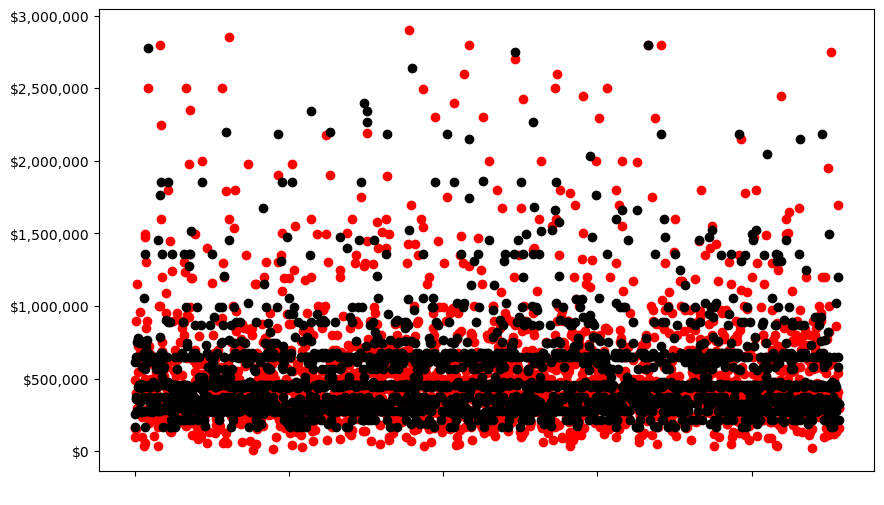

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(dtree_bp_predict_df.index,dtree_bp_predict_df["prediction"], color="black")
plt.show()

#### Scatter Plot graph of the results of Recursive Feature Elimination, Sequential Feature Selection, and Test Data.

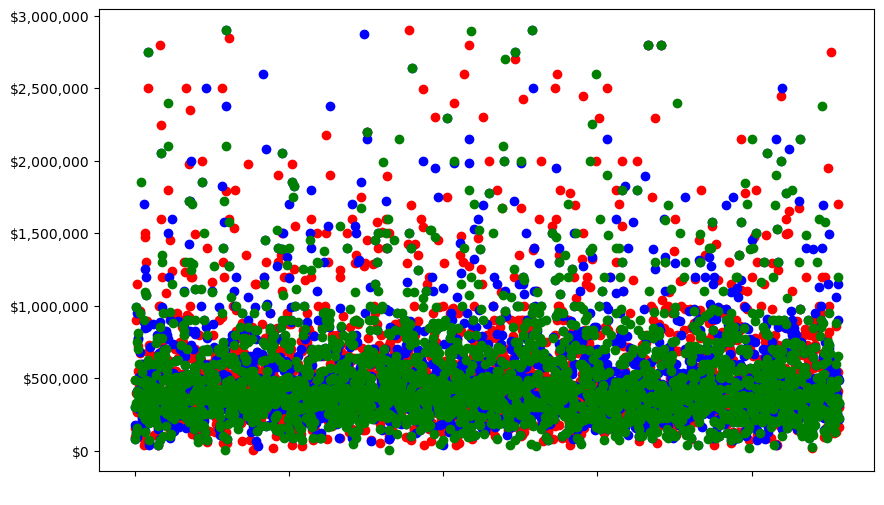

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(dtree_rfe_predict_df.index,dtree_rfe_predict_df["prediction"], color="blue")
plt.scatter(dtree_sfs_predict_df.index,dtree_sfs_predict_df["prediction"], color="green")
plt.show()

#### Output the results so they can be copied into another Notebook comparing the results of all the models.

In [19]:
results_dict

{'model': ['Decision Tree Best Params',
  'Recursive Feature Elimination',
  'Sequential Feature Selector'],
 'explained variance score': ['0.525465856', '0.440904030', '0.303556745'],
 'mae score': ['161,667.633996', '167,341.540176', '196,248.431572'],
 'mse score': ['76,497,959,521.268478',
  '90,111,993,366.970032',
  '112,185,588,919.390549'],
 'r2 score': ['0.524659', '0.440065', '0.302905'],
 'mean fit time': [0.009049510955810547,
  0.02732996940612793,
  0.02500143051147461]}

In [20]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score,mean fit time
model,,,,,
Decision Tree Best Params,0.525465856,"161,667.633996","76,497,959,521.268478",0.524659,0.009050
Recursive Feature Elimination,0.440904030,"167,341.540176","90,111,993,366.970032",0.440065,0.027330
Sequential Feature Selector,0.303556745,"196,248.431572","112,185,588,919.390549",0.302905,0.025001
